In [1]:
import copy
import time
import cyclum.tuning
import cyclum.models

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

from data_gen import *
from datasets import *
#cr_filtering()
#cr_read_norm()1dasdas
import h5py
import scanpy as sc
from sklearn.metrics import adjusted_rand_score
n_obs=1000 #number of observations per timepoint


In [2]:
adata = read_liver_data_2(n_obs=n_obs) #read data
adata = sort_data_crit(adata=copy.deepcopy(adata.copy()),crit='ZT',crit_list=['0','6','12','18']) #sort the data according to the timepoints
adata

Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_

View of AnnData object with n_obs × n_vars = 4000 × 14812
    obs: 'ZT', 'layer', 'batch'

In [3]:

#standard pre-processing
sc.pp.filter_genes(adata, min_cells=3)
sc.pp.filter_cells(adata, min_genes=500)
sc.pp.normalize_per_cell(adata, counts_per_cell_after=1e4)
sc.pp.log1p(adata)
sc.pp.filter_genes_dispersion(adata, n_top_genes=7000)
orig_adata = copy.deepcopy(adata.copy())



Trying to set attribute `.var` of view, copying.


In [4]:
model = cyclum.tuning.CyclumAutoTune(adata.X, max_linear_dims=10,
                                         epochs=500, rate=2e-4, verbose=100,
                                         encoder_width=[20, 30]) #500, 10
model.train(adata.X, epochs=1000, verbose=100, rate=2e-4) #1000
pseudotime = model.predict_pseudotime(adata.X)


Auto tuning number of linear components...
Performing PCA...
Training Autoencoder with...
    0 linear dimensions...


2022-09-20 22:01:12.684177: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


epoch: 100/500, loss:  0.1666, time elapsed:  85.35s, time left:  341.40s
epoch: 200/500, loss:  0.1611, time elapsed:  145.98s, time left:  218.97s
epoch: 300/500, loss:  0.1605, time elapsed:  195.33s, time left:  130.22s
epoch: 400/500, loss:  0.1604, time elapsed:  248.24s, time left:  62.06s
epoch: 500/500, loss:  0.1604, time elapsed:  297.27s, time left:  0.00s
[0.16038593649864197]
[0.29875594, 0.29593495, 0.2940118, 0.2923652, 0.29105026, 0.29032815, 0.28976044, 0.28934568, 0.28894857, 0.28857794, 0.28826776, 0.28798774]
    1 linear dimensions...
epoch: 100/500, loss:  0.1581, time elapsed:  52.22s, time left:  208.87s
epoch: 200/500, loss:  0.1580, time elapsed:  103.68s, time left:  155.51s
epoch: 300/500, loss:  0.1579, time elapsed:  153.71s, time left:  102.47s
epoch: 400/500, loss:  0.1579, time elapsed:  202.44s, time left:  50.61s
epoch: 500/500, loss:  0.1579, time elapsed:  251.48s, time left:  0.00s
[0.16038593649864197, 0.1579018533229828]
[0.29875594, 0.29593495,

In [5]:
circular_comp = model.get_circular_component(pseudotime)
flat_embedding = (pseudotime % (2 * np.pi)) / 2
flat_embedding = flat_embedding[:,0]
sort= np.argsort(flat_embedding)
bdata = adata.copy()
bdata = bdata[sort,:]
adata_circular = bdata.copy()
adata_circular.X = circular_comp
adata_filtered = bdata.copy()
adata_filtered.X = adata_filtered.X- circular_comp


In [6]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_filtered.obs['layer']))



kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_filtered.X)
print(adjusted_rand_score(kmeans.labels_ , adata_filtered.obs['ZT']))


0.059846276948843084
0.10435508630421685


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


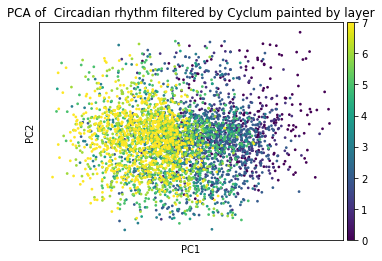

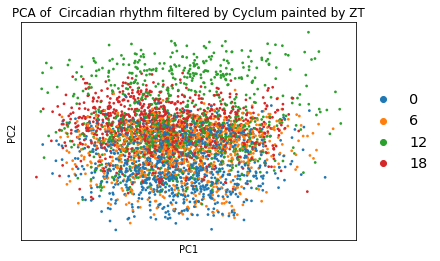

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


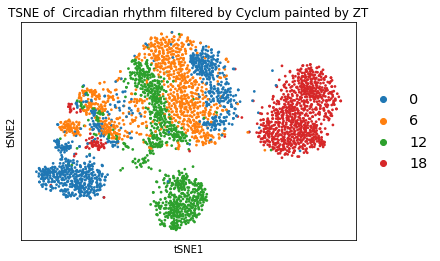

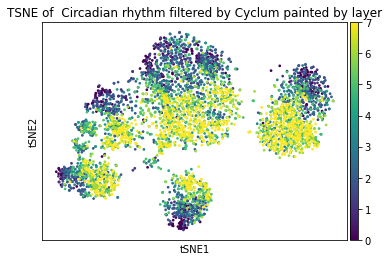

In [9]:
plots_liver(adata_filtered,title=" Circadian rhythm filtered by Cyclum")


In [8]:
def plots_liver(adata,title):
    sc.pp.neighbors(adata)
    sc.tl.pca(adata)
    sc.pl.pca_scatter(adata, color='layer' , title=("PCA of " + title + " painted by layer"), legend_fontsize='x-large')
    sc.pl.pca_scatter(adata, color='ZT' , title=("PCA of " + title + " painted by ZT"), legend_fontsize='x-large')
    sc.tl.tsne(adata)
    sc.pl.tsne(adata, color='ZT' , title=("TSNE of " + title + " painted by ZT"), legend_fontsize='x-large')
    sc.pl.tsne(adata, color='layer' , title=("TSNE of " + title + " painted by layer"), legend_fontsize='x-large')

    pass

In [10]:
kmeans = KMeans(n_clusters=8, random_state=0).fit(adata_circular.X)
print(adjusted_rand_score(kmeans.labels_ , adata_circular.obs['layer']))



kmeans = KMeans(n_clusters=4, random_state=0).fit(adata_circular.X)
print(adjusted_rand_score(kmeans.labels_ , adata_circular.obs['ZT']))


0.003030456681291777
0.0011401909106899721


         Falling back to preprocessing with `sc.pp.pca` and default params.


/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/anndata/_core/anndata.py:1228: FutureWarning: The `inplace` parameter in pandas.Categorical.reorder_categories is deprecated and will be removed in a future version. Reordering categories will always return a new Categorical object.
  c.reorder_categories(natsorted(c.categories), inplace=True)
... storing 'ZT' as categorical


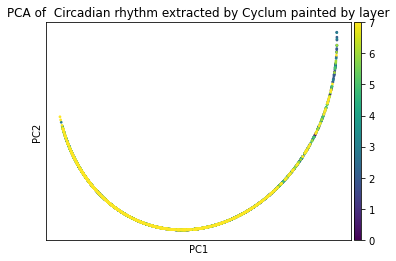

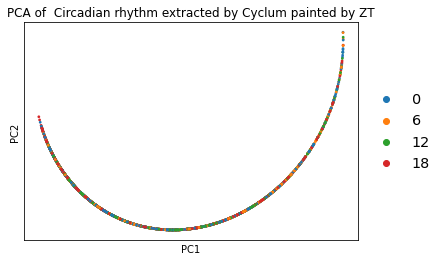

/Users/jonathankarin/.conda/envs/cyclum/lib/python3.7/site-packages/sklearn/manifold/_t_sne.py:783: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  FutureWarning,


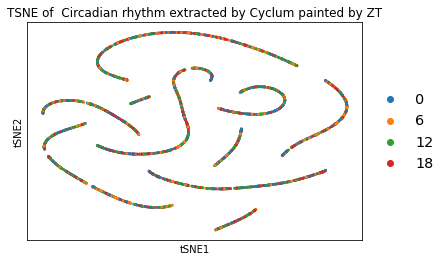

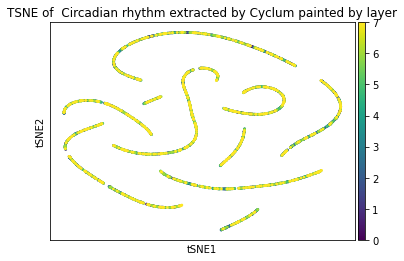

In [11]:
plots_liver(adata_circular,title=" Circadian rhythm extracted by Cyclum")
